In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
from tqdm import tqdm
import xgboost as xgb

#### Output file

In [2]:
sourceFile = open("gpu_logs/shared_40best.txt", 'w')

### Load the data

In [ ]:
df = pd.read_csv("data/shared_all_records.csv")
df.reset_index(drop=True, inplace=True)
df = df.iloc[:, [0, 2, 1]]
df['Time'] =  pd.to_datetime(df['Time'])
df

In [ ]:
## Number of houses
df.Location.nunique()

In [ ]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

In [ ]:
## Number of records per house
df.Location.value_counts()

In [ ]:
#df.to_csv("../datasets/shared_complete.csv", index=False)

### Auxiliary functions

In [3]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores

In [4]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)

def past_timesteps(df, number_of_timesteps):
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# def last_energy_points_full(df, number_timesteps, num_samples_per_house):
#     X = pd.DataFrame()
#     other_feats = df.iloc[:,:2]
#     for i in range(1, (number_timesteps + 1) ):
#         X[f'Energy_{i*15}'] = df['Energy'].shift(i)
#     y = df.copy().iloc[:,2]
#     y.iloc[:number_timesteps] = np.nan
#     ## Remove samples in between each house
#     for h in range(1, number_of_houses):
#         for i in range(0, number_timesteps):
#             X.iloc[(num_samples_per_house+i)*h] = np.nan
#             y.iloc[(num_samples_per_house+i)*h] = np.nan
#     X = pd.concat([other_feats, X], axis=1)
#     X.dropna(inplace=True)
#     X.reset_index(drop=True, inplace=True)
#     y.dropna(inplace=True)
#     y.reset_index(drop=True, inplace=True)
#     y.columns = ["Energy"]
#     dataframe = pd.concat([X,y.rename('Energy')], axis=1)
#     assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
#     return dataframe
    

In [5]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

### Cross Validate

In [ ]:
#scores = validate(model, X_train, y_train)
#cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
#cv_r2 = np.round(scores['test_r2'].mean(),5)
#print("CV MSE: {} ".format(cv_mse))
#print("CV R2: {} ".format(cv_r2))
#metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

## Leave 10 houses for test (demonstration)

In [ ]:
number_of_timesteps = 672

In [ ]:
locations = np.random.choice(df['Location'].unique(), size=3, replace=False)
locations

In [ ]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

In [ ]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5,6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

In [ ]:
df_new.to_csv("data/shared_oneweek.csv", index=False)

In [6]:
def test_leave_house_out(df, estimator, locations, filename):
    # df_new = past_timesteps(df, number_timesteps)
    # df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
    # df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5,6]).astype(int)
    # df_new['Hour'] = df_new['Time'].dt.hour
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Predict  10 folds with 10 random houses for test

In [7]:
df = pd.read_csv("data/shared_best40features.csv")
df

,Time,Location,energy_lag_1,energy_lag_398,energy_lag_87,energy_lag_249,energy_lag_190,energy_lag_671,energy_lag_459,energy_lag_93,...,energy_lag_20,energy_lag_433,energy_lag_82,energy_lag_152,energy_lag_2,energy_lag_641,energy_lag_66,energy_lag_210,energy_lag_340,Energy
0,2020-10-13 00:15:00,PT41CV,0.080,0.064,0.056,0.112,0.112,0.072,0.080,0.040,...,0.088,0.080,0.052,0.028,0.084,0.056,0.080,0.116,0.032,0.036
1,2020-10-13 00:30:00,PT41CV,0.036,0.116,0.056,0.032,0.028,0.072,0.104,0.064,...,0.092,0.088,0.052,0.072,0.080,0.112,0.084,0.048,0.036,0.084
2,2020-10-13 00:45:00,PT41CV,0.084,0.040,0.056,0.036,0.036,0.068,0.028,0.064,...,0.084,0.032,0.052,0.096,0.036,0.028,0.060,0.028,0.116,0.104
3,2020-10-13 01:00:00,PT41CV,0.104,0.028,0.056,0.120,0.120,0.032,0.048,0.060,...,0.088,0.064,0.052,0.032,0.084,0.040,0.064,0.100,0.048,0.036
4,2020-10-13 01:15:00,PT41CV,0.036,0.116,0.056,0.044,0.056,0.040,0.116,0.060,...,0.084,0.108,0.052,0.048,0.104,0.116,0.064,0.080,0.028,0.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554229,2022-11-25 00:00:00,PT87ZW,0.812,1.172,0.616,0.532,0.560,0.472,0.464,0.732,...,1.032,0.772,0.688,0.532,0.756,0.584,0.848,2.004,0.560,0.764
554230,2022-11-25 00:15:00,PT87ZW,0.764,1.040,0.612,0.468,0.700,0.532,0.468,0.628,...,1.980,0.884,0.600,0.552,0.812,0.576,0.688,0.912,0.480,0.660
554231,2022-11-25 00:30:00,PT87ZW,0.660,0.976,0.636,0.432,0.600,0.520,0.488,0.632,...,1.872,0.864,0.620,0.560,0.764,0.544,0.648,0.992,0.572,0.692
554232,2022-11-25 00:45:00,PT87ZW,0.692,0.988,0.644,0.428,0.600,0.440,0.320,0.628,...,0.688,1.772,0.628,0.472,0.660,0.508,0.720,0.968,0.708,0.660


In [8]:
df.isna().sum().sum()

0

In [9]:
num_houses_test = 3

In [10]:
locations = []
for i in range(10):
    np.random.seed(i*4)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['PT48JB', 'PT87ZW', 'PT69QG'], dtype=object),
 array(['PT15VP', 'PT69QG', 'PT48JB'], dtype=object),
 array(['PT87RW', 'PT17RW', 'PT51SH'], dtype=object),
 array(['PT51SH', 'PT07ZR', 'PT17RW'], dtype=object),
 array(['PT87RW', 'PT42JN', 'PT41CV'], dtype=object),
 array(['PT87RW', 'PT44AL', 'PT43QL'], dtype=object),
 array(['PT87ZW', 'PT07ZR', 'PT17RW'], dtype=object),
 array(['PT87ZW', 'PT42JN', 'PT51SH'], dtype=object),
 array(['PT41CV', 'PT17RW', 'PT42JN'], dtype=object),
 array(['PT15VP', 'PT41CV', 'PT48JB'], dtype=object)]

### Linear Regression

In [11]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

Train set:  (407465, 43)
Test set:  (146769, 43)
Train set:  (443753, 43)
Test set:  (110481, 43)
Train set:  (393087, 43)
Test set:  (161147, 43)
Train set:  (439723, 43)
Test set:  (114511, 43)
Train set:  (402960, 43)
Test set:  (151274, 43)
Train set:  (399895, 43)
Test set:  (154339, 43)
Train set:  (400555, 43)
Test set:  (153679, 43)
Train set:  (419071, 43)
Test set:  (135163, 43)
Train set:  (373967, 43)
Test set:  (180267, 43)
Train set:  (406029, 43)
Test set:  (148205, 43)


### XGBoost

In [12]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

Train set:  (407465, 43)
Test set:  (146769, 43)
Train set:  (443753, 43)
Test set:  (110481, 43)
Train set:  (393087, 43)
Test set:  (161147, 43)
Train set:  (439723, 43)
Test set:  (114511, 43)
Train set:  (402960, 43)
Test set:  (151274, 43)
Train set:  (399895, 43)
Test set:  (154339, 43)
Train set:  (400555, 43)
Test set:  (153679, 43)
Train set:  (419071, 43)
Test set:  (135163, 43)
Train set:  (373967, 43)
Test set:  (180267, 43)
Train set:  (406029, 43)
Test set:  (148205, 43)


### Random Forest

In [13]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

Train set:  (407465, 43)
Test set:  (146769, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (443753, 43)
Test set:  (110481, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (393087, 43)
Test set:  (161147, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (439723, 43)
Test set:  (114511, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (402960, 43)
Test set:  (151274, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (399895, 43)
Test set:  (154339, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (400555, 43)
Test set:  (153679, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (419071, 43)
Test set:  (135163, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (373967, 43)
Test set:  (180267, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (406029, 43)
Test set:  (148205, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [14]:
print("\n\n\n", file=sourceFile)

In [15]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [16]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [17]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

In [20]:
sourceFile.close()

### Feature Importance

In [18]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: 10.37516
Feature: 1, Score: 0.01851
Feature: 2, Score: 0.11453
Feature: 3, Score: 0.02808
Feature: 4, Score: 0.20561
Feature: 5, Score: 0.62322
Feature: 6, Score: 0.05595
Feature: 7, Score: 0.23518
Feature: 8, Score: 0.01361
Feature: 9, Score: -0.00343
Feature: 10, Score: 0.57494
Feature: 11, Score: 0.11135
Feature: 12, Score: -0.03685
Feature: 13, Score: 0.29513
Feature: 14, Score: 0.01667
Feature: 15, Score: 0.00514
Feature: 16, Score: 0.09767
Feature: 17, Score: 0.96528
Feature: 18, Score: 0.00326
Feature: 19, Score: 0.59032
Feature: 20, Score: 0.02674
Feature: 21, Score: 0.01490
Feature: 22, Score: 0.06945
Feature: 23, Score: 0.44904
Feature: 24, Score: -0.02822
Feature: 25, Score: 0.22197
Feature: 26, Score: 0.03539
Feature: 27, Score: -0.05425
Feature: 28, Score: -0.02455
Feature: 29, Score: 0.36802
Feature: 30, Score: 0.38966
Feature: 31, Score: 0.21131
Feature: 32, Score: 0.00864
Feature: 33, Score: 0.13396
Feature: 34, Score: -0.00967
Feat

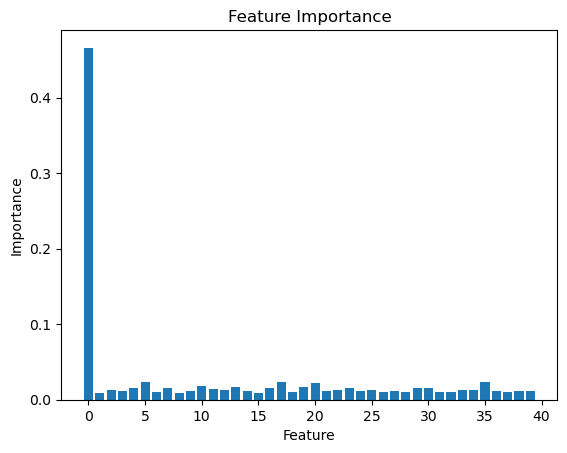

In [19]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

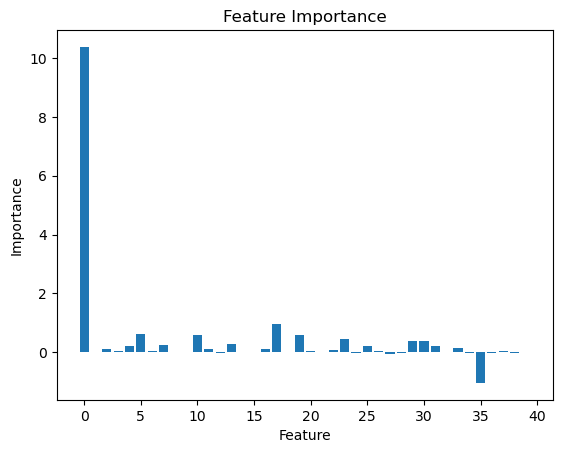

In [21]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

In [ ]:
features = feature_importance.nlargest(40).index
features

In [ ]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

In [ ]:
df_40.to_csv("data/shared_best40features.csv", index=False)